In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.initialize_interpolation_grid(500, grid_bounds=[(0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel().cuda()
model.condition(train_x, train_y)

KissGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [4]:
# Optimize the model
def train():
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(output, train_y) * 1. / len(train_x)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()

    _ = model.eval()
    
%time train()

/home/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/30 - Loss: 1.150
Iter 2/30 - Loss: 1.124
Iter 3/30 - Loss: 1.090
Iter 4/30 - Loss: 1.064
Iter 5/30 - Loss: 1.032
Iter 6/30 - Loss: 1.015
Iter 7/30 - Loss: 0.984
Iter 8/30 - Loss: 0.967
Iter 9/30 - Loss: 0.934
Iter 10/30 - Loss: 0.910
Iter 11/30 - Loss: 0.887
Iter 12/30 - Loss: 0.856
Iter 13/30 - Loss: 0.815
Iter 14/30 - Loss: 0.756
Iter 15/30 - Loss: 0.690
Iter 16/30 - Loss: 0.613
Iter 17/30 - Loss: 0.524
Iter 18/30 - Loss: 0.425
Iter 19/30 - Loss: 0.344
Iter 20/30 - Loss: 0.271
Iter 21/30 - Loss: 0.196
Iter 22/30 - Loss: 0.143
Iter 23/30 - Loss: 0.095
Iter 24/30 - Loss: 0.052
Iter 25/30 - Loss: 0.009
Iter 26/30 - Loss: -0.025
Iter 27/30 - Loss: -0.053
Iter 28/30 - Loss: -0.079
Iter 29/30 - Loss: -0.104
Iter 30/30 - Loss: -0.109
CPU times: user 2.99 s, sys: 4.77 s, total: 7.76 s
Wall time: 7.88 s


In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51)).cuda()
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
        ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
        ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

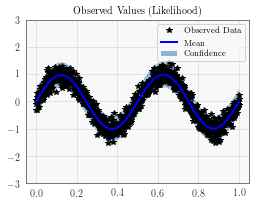

In [7]:
f = plot_model_and_predictions(model, plot_train_data=True)